# Simple regression for a bimodal distribution 
It's the same example from the original repo: https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector


In [1]:
%cd ..

/users/fzanetta/pyprojects/bernstein-flow


/scratch-shared/meteoswiss/scratch/fzanetta/mambaforge/envs/jax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:

import typing as tp
import functools as ft

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from flax.experimental import nnx
import optax as ox
from jaxtyping import Float, Array
import scoringrules as sr
from sklearn.utils import shuffle


from bernstein_flow.flow import BernsteinFlow
from bernstein_flow.bijectors import Bernstein, Softclip

sr.register_backend("jax")
# jax.config.update("jax_disable_jit", True)

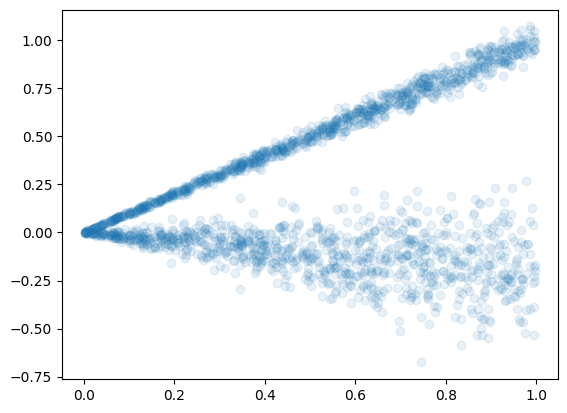

In [3]:
def gen_data(t):
    t1=t
    y1=1.0*t1
    y1+=np.random.normal(0,0.05*np.abs(t1))
    t2=t
    y2=-.2*t2
    y2+=np.random.normal(0,0.2*np.abs(t2))
    t=np.concatenate([t1,t2])
    y=np.concatenate([y1,y2])
    return shuffle(t[...,np.newaxis], y[...,np.newaxis], random_state=0)

def gen_test_data(n=5, observations=100):
    t = np.linspace(0,1,n, dtype=np.float32)
    t=np.repeat([t],observations)

    return gen_data(t)

def gen_train_data(n=100):
    t = np.random.uniform(0,1,n//2).astype(np.float32)
    return gen_data(t)

n = 2000
train_x,train_y = gen_train_data(n = n)
val_x, val_y = gen_train_data(n = n//10)
train_x.shape,train_y.shape, val_x.shape,val_y.shape

plt.scatter(train_x,train_y, alpha=0.1)

In [4]:
jnp.clip(0.1, 0.0)[...,None]

Array([0.1], dtype=float32, weak_type=True)

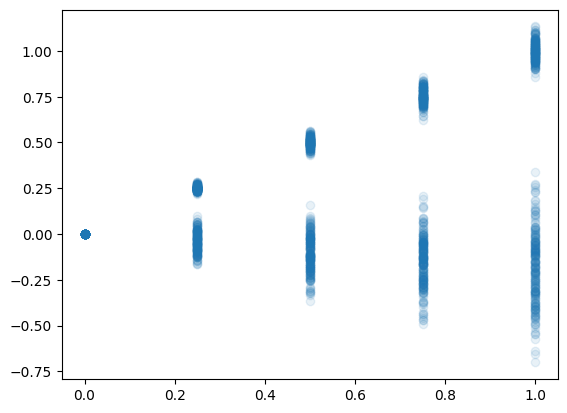

In [5]:
t_test, y_test = gen_test_data(5, 200)
x_test = np.unique(t_test)
plt.scatter(t_test, y_test, alpha=0.1)

In [6]:
def dataloader(x, y, batch_size, *, key, shuffle=True):
    dataset_size = x.shape[0]
    indices = jnp.arange(dataset_size)
    perm = indices
    while True:
        if shuffle:
            perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield jnp.array(x[batch_perm]), jnp.array(y[batch_perm])
            start = end
            end = start + batch_size


class BernsteinFlowRegressor(nnx.Module):
    def __init__(
        self,
        din: int,
        hidden: list[int],
        dout: int,
        *,
        key: jax.Array,
    ):
        h = [din] + hidden
        rngs = [nnx.Rngs(k) for k in jr.split(key, len(h))]
        self.hidden = [nnx.Linear(h[i], h[i + 1], rngs=rngs[i]) for i in range(len(h) - 1)]
        self.hidden = nnx.Sequence(self.hidden)
        self.out = nnx.Linear(hidden[-1], dout, rngs=rngs[-1])
    
    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.tanh(x)
        return BernsteinFlow(self.out(x))
    
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["nll"] = train_loss
            return carry, log

        scan = jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 0.0)

        def loss_fn(params):
            flow, _ = state.apply(params)(x)
            flow: BernsteinFlow
            return jnp.mean(-flow.log_prob(y), where=mask)
        
        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        flow, _ = state.apply("params")(x)
        crps = jnp.nanmean(-flow.log_prob(y[...,0]))
        return {"val_nll": crps}

In [7]:
key = jr.key(42)

In [8]:
theta = jnp.asarray([-1.07, -0.64, -0.44, 0.79, 1.92, 2.14, 2.42, 3.16, 3.39])

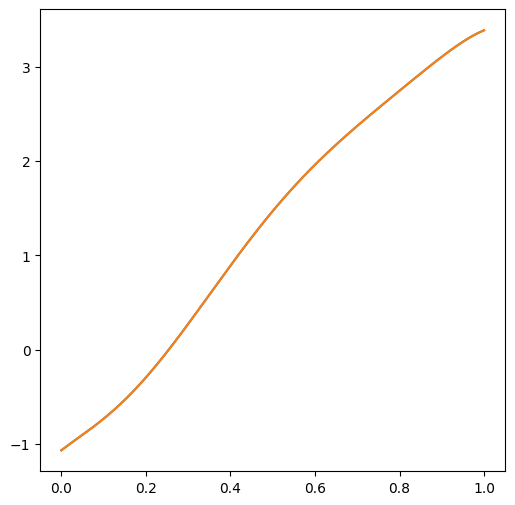

In [9]:
np.random.seed(2)

key, _ = jr.split(key)
# bs = Bernstein(theta[None].repeat(32, 0), constrained=True)
bs = Bernstein(theta, constrained=True)
# bs = Bernstein(np.random.normal(0, 1, (1,9)))
# y = 1.2
yy = np.linspace(0, 1, 200, dtype=np.float32)
zz = bs.forward(yy)
# Prevent caching -> use spline interpolation
zi = zz + 1e-15 * np.random.random(zz.shape)
yyy = bs.inverse(zi)

plt.figure(figsize=(6, 6))
plt.plot(yy, zz)
plt.plot(yyy, zi)


In [10]:
from bernstein_flow.distributions import StandardNormal
import scipy.stats as stats

print(StandardNormal().log_prob(0.0))
print(stats.norm.logpdf(0.0))


-0.9189385
-0.9189385332046727


(10000,)


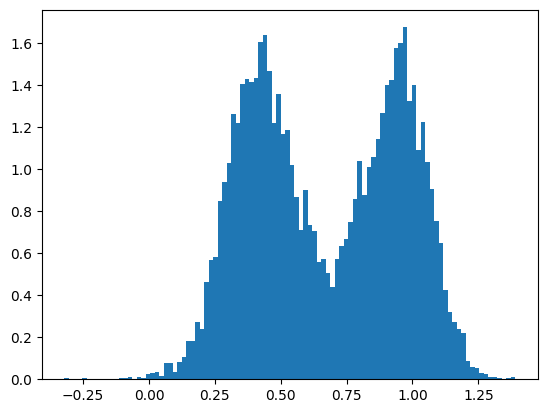

In [11]:
a1 = np.array([6], dtype=np.float32)
b1 = np.array([-3], dtype=np.float32)
theta = np.array([-2 ,  2,  3, -7, -7, -7, -7, -7, 7], dtype=np.float32)
a2 = np.array([0.2], dtype=np.float32)
b2 = np.array([-2.5], dtype=np.float32)
flow = BernsteinFlow(np.concatenate([a1,b1,theta,a2,b2]))
samples = flow.sample(key, 10000)
print(samples.shape)
plt.hist(np.array(samples).ravel(), bins=100, density=True);

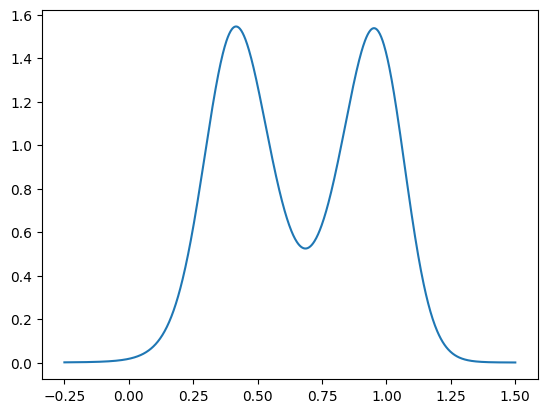

In [12]:
z = np.linspace(-0.25, 1.5, 1000, dtype=np.float32)
plt.plot(z, flow.prob(z))

In [15]:
net = BernsteinFlowRegressor(1, [32], 36, key=jr.PRNGKey(0))

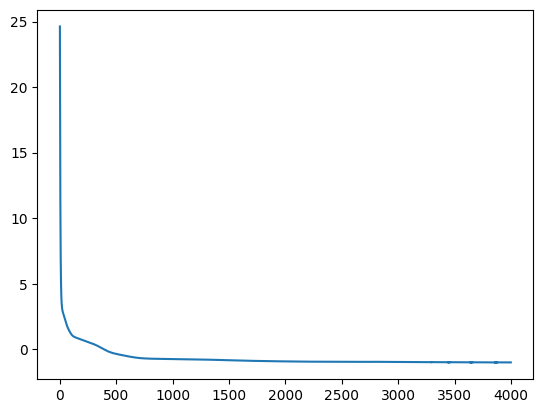

In [16]:
net, history = net.fit(
    train_x,
    train_y,
    (val_x, val_y),
    key=jr.PRNGKey(0),
    # opt=ox.sgd(0.003, momentum=0.9, nesterov=True),
    opt=ox.adabelief(0.003),
    batch_size=128,
    n_steps=4000,
)

plt.plot(history["val_nll"])

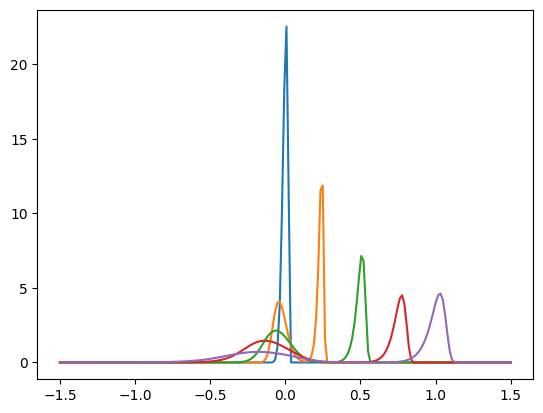

In [17]:
flow = net(x_test[:,None])
yy = jnp.linspace(-1.5, 1.5, 200)[:,None]
ps = flow.prob(yy)
plt.plot(yy, ps)

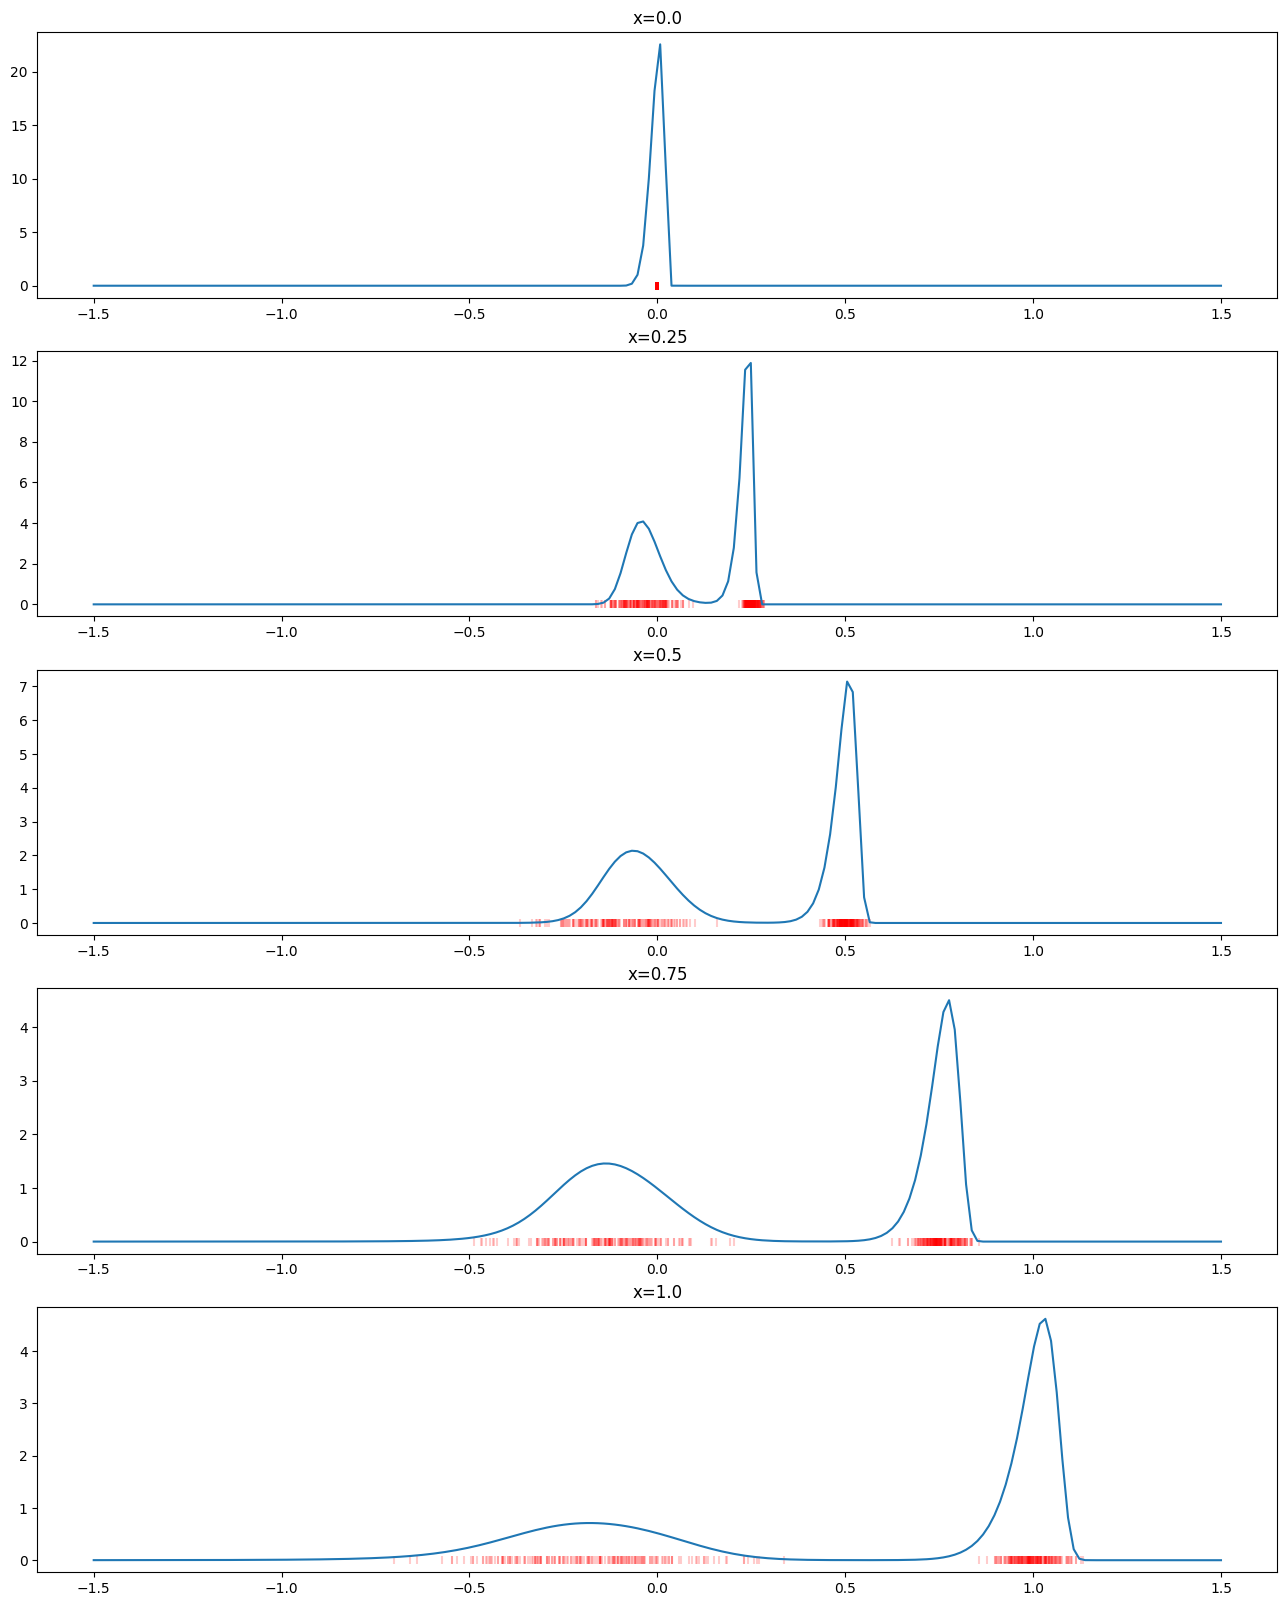

In [18]:
fig, ax = plt.subplots(len(x_test), figsize=(16, len(x_test)*4))
for i,x in enumerate(x_test):
    ax[i].set_title(f'x={x}')
    sampl=y_test[(t_test.flatten()==x)].flatten()
    ax[i].scatter(sampl, [0]*len(sampl), marker='|', alpha=0.2, color="r")
    ax[i].plot(yy,ps[:,i])